---
layout: posts
title:  "NERF"
date:   2023-10-04s
categories: COMPUTER-VISION
permalink: /:categories/:title
toc: true
created: true
classes: wide
---

# Understanding Neural Radiance Fields (NeRF)
This notebook is a minimal implementation in PyTorch of the paper [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934) by Ben Mildenhall, Pratul P. Srinivasan, Matthew Tancik, Jonathan T. Barron, Ravi Ramamoorthi, & Ren Ng. Through this notebook I will also cover the theory behind the paper and the code.

## Introduction
Nerf is a generative model, conditioned on a collection of images with known accurate poses (position and rotation), that allows generation of new views of the 3D scene captured by the trained images. This is also known as *"novel view synthesis*. This is done by using a neural network to estimate the volume density (transparency) and view dependent radiance (RGB color). Taking the output of the network, and calculating the volume rendering integral, we can calculate the color of every pixel in the image.

In computer graphics, a continuous scene can be described as a 5D vector function whose input is a 3D location $\mathbf{x}=(x,y,z)$ and a viewing direction $\mathbf{d}=(\theta,\phi)$, and whose output is an emitted color $\mathbf{c}=(r,g,b)$ and volume density $\sigma$. 

Nerf estimates this continuous 5D scene representation by a *MLP* (multilayer perceptron network) $F_\Theta$, so that:
$$ 
F_{\Theta}: (\mathbf{x},\mathbf{d}) \rightarrow (\sigma,\mathbf{c})
$$

and optimize its weight $\Theta$ to minimize the error between the rendered image and the ground truth image with known location and viewing direction.

![Nerf overview](assets/nerf_overview.webp)

### To generate a neural radiance field we follow the following steps:
1. Project camera rays through the scene.
2. Along each ray, generate a collection of 3D points called **query points**.
3. Use the **query points** as the inputs to a neural network, and estimate the volume density $\sigma$ and emitted color $\mathbf{c}=(r,g,b)$ for each point.
4. Use the ***volume rendering integral*** from computer graphics to accumulate the color and density of each query point, into the color of the ray on the camera image plane: 
$$
C(\mathbf{r}) = \int_{t_n}^{t_f} T(t) \sigma(\mathbf{r}(t))\mathbf{c}(\mathbf{r}(t))dt 
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where

$$
   T(t)=exp(-\int_{t_n}^{t}\sigma(\mathbf{r}(s))ds) 
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;is the accumulated transparency of the ray up to point $t$.

5. The loss of the MLP is the difference between the rendered image and the ground truth image: 
$$
L = \sum_{i,j}||\mathbf{c}_{i,j} - \mathbf{c}_{i,j}^{gt}||_2^2
$$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation
First, lets load the dataset:

In [2]:
import os
import wget
if not os.path.exists('data/tiny_nerf_data.npz'):
    !wget.download('http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz', 'data/tiny_nerf_data.npz')    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The dataset consists of 106 of images of a synthetic lego. Each image is accompanied with the camera pose (position and rotation). The focal length of the camera used to capture the scene is also given. 
The coordinates of the camera poses, is a transformation of **camera coordinates** to **world coordinates**, so that the following equation holds:

$$
X_w = P X_c
$$

where $P = [R|t]$ describes the rotation and translation of the camera relative to the world, and $X_w$ and $X_c$ are homogeneous coordinates of a point in world and camera coordinates respectively.
$$ 
\begin{bmatrix} x_w \\ y_w \\ z_w \\ 1 \end{bmatrix} =

\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1\\
                r_{21} & r_{22} & r_{23} & t_2\\
                r_{31} & r_{32} & r_{33} & t_3 \\
                  0    &   0    &   0    & 1 \\
\end{bmatrix} = 
 
\begin{bmatrix} x_c \\ y_c \\ z_c \\ 1 \end{bmatrix}
$$

Now, given the pose of each camera in world coordinates we can do two important things:
1. Plot the camera positions in 3D space.
2. Calculate the ray bundle of each camera passing through the image plane. This is important for estimating the volume density and view dependent radiance.

In [3]:
data = np.load('data/tiny_nerf_data.npz')
poses = torch.from_numpy(data['poses']).to(device)
images = torch.from_numpy(data['images']).to(device)
focal =  torch.from_numpy(data['focal']).to(device)

print('\n')
print(f'Focal length:', focal.item())
print(f'Number of images:', images.shape[0])
print(f'Poses shape:', poses.shape)




Focal length: 138.88887889922103
Number of images: 106
Poses shape: torch.Size([106, 4, 4])


### Calculate the camera origins and directions
The camera origins are simply the translation part of the camera pose $P$ matrix. To calculate the camera directions, we need to project the optical axis of the camera: $\vec{z}=[0,0,-1]$ to world coordinates.

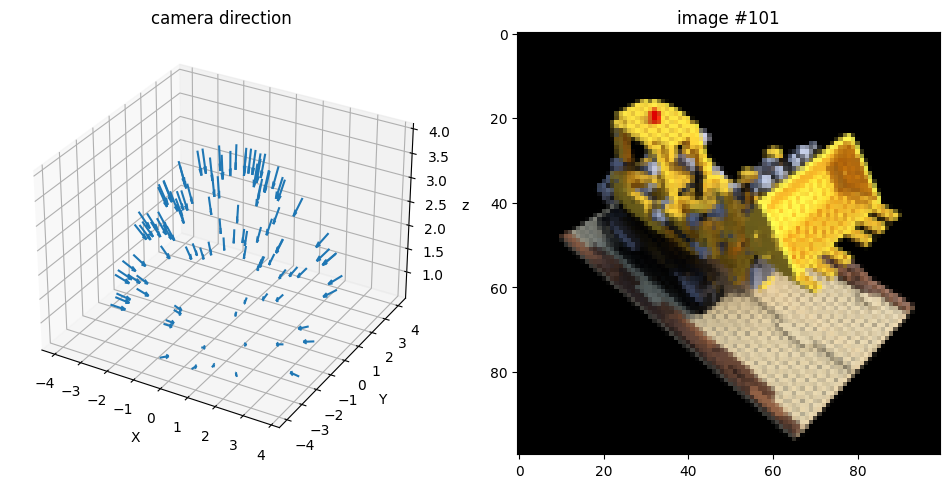

Pose of image #101:
tensor([[ 6.8935e-01,  5.3373e-01, -4.8982e-01, -1.9745e+00],
        [-7.2443e-01,  5.0789e-01, -4.6611e-01, -1.8789e+00],
        [ 1.4901e-08,  6.7615e-01,  7.3676e-01,  2.9700e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')


In [4]:
cam_dirs = np.stack([pose[:3, :3] @ np.array([0, 0, -1]) for pose in poses.cpu().numpy()])
cam_origins = np.stack([pose[:3, -1] for pose in poses.cpu().numpy()])

ax = plt.figure('camera origin and direction', figsize=(12,8)).add_subplot(121, projection='3d')
ax.quiver(cam_origins[:,0], cam_origins[:,1], cam_origins[:,2], cam_dirs[:,0], cam_dirs[:,1], cam_dirs[:,2], length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z') 
ax.set_title('camera direction')

# add another plot to ax
ax = plt.subplot(122)

ax.imshow(data['images'][101])
ax.set_title('image #101')

plt.show()
print(f'Pose of image #101:\n{poses[101]}')


### Calculate the ray bundle of each camera
To create the query points along each ray, we need to calculate the ray bundle of each camera.

The ray bundle of each camera is a set of rays passing through the image plane If the image has MxN pixels, it has MxN rays, each passing through a pixel. Each ray is defined by the parametric equation: 

$$
\vec{r}(t) = \vec{o} + t \vec{R}
$$


where $\vec{o}$ is the origin of the ray, $\vec{R}$ is the direction of the ray, and $t$ is the parameter, which we now know from the camera pose given in the data set.

![Pinhole model](assets/pinhole-camera-model.png)




In [5]:
def get_rays(height: int, width: int, focal_length: int, cam2world: torch.Tensor):
    """
    Get rays origin and direction in the world coordinate system, using pinhole camera model.
    Args:
        height (int): image height
        width (int): image width
        focal_length (int): focal length
        cam2world (torch.Tensor): camera to world transformation matrix
    Returns:
        rays_origins (torch.Tensor): rays origins in the world coordinate system
        rays_directions (torch.Tensor): rays directions in the world coordinate system
    """

    # Apply pinhole camera model to gather ray origins and directions:
    x = torch.arange(width, dtype=torch.float32).to(cam2world)
    y = torch.arange(height, dtype=torch.float32).to(cam2world)
    i, j = torch.meshgrid(x,y, indexing='ij')

    # Get ray directions
    dirs = torch.stack([(j - width * 0.5) / focal_length, 
                        -(i - height * 0.5) / focal_length, 
                        -torch.ones_like(i)
                        ], dim=-1)
    
    # transform ray directions from camera space to world space
    rays_directions = torch.sum(dirs[..., None, :] * cam2world[:3, :3], dim=-1)

    # ray origins are the camera origins
    rays_origins = cam2world[:3, -1].expand(rays_directions.shape)

    return rays_origins, rays_directions

## Calculate query points along each ray
Now that we have the ray bundle of each camera, we need to sample **query points** along each ray. In the paper, they use a coarse-to-fine sampling approach, starting from stratified sampling. Stratified sampling splits the ray into $N$ evenly spaced bins, and randomly samples a point from each bin. The random sampling encourages the network to learn over a continuous space.

![stratified_sampling](assets/stratified_sampling.gif)

In [6]:
def compute_query_points_from_rays(
        ray_origins: torch.Tensor,
        ray_directions: torch.Tensor,
        near_threshold: float,
        far_threshold: float,
        num_samples: int,
        randomize: bool = True
        ) -> (torch.Tensor, torch.Tensor):
    """
        Compute query 3D points along each ray. The near and far thresholds indicate the bounds
        within which 3D points are to be sampled.
        There are two ways to perform this sampling: 
        1. uniformly sample along each ray
        2. Split the rays into evenly spaced intervals and sample randomly within these segments
    """

    depth_values = torch.linspace(near_threshold, far_threshold, num_samples).to(ray_origins)
    if randomize:
        bin_width = (far_threshold - near_threshold) / num_samples
        # random values to add to each bin:
        noise = torch.rand_like(depth_values) * bin_width
        depth_values += noise

    # Compute the query points: 
    # These are points along the ray with length specified by depth_values
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., None]

    # query_points [W, H, num_samples, 3]
    # check depth_values [num_samples]
    return query_points, depth_values


## Volume Rendering
The MLP network outputs the color and volume density of each query point. Now we need to use this information, and build the color value of every pixel in the image. This is done by integrating the density and color along a ray using the volume rendering integral, all the way to the camera image plane

Writing the volume integral in discrete form, we get:

$$
C(\bold{r}) = \sum_{i=1}^{N} T_i (1-exp(-\sigma_i \Delta_i)) \bold{c}_i\\
T_i = exp(-\sum_{j=1}^{i-1} \sigma_j \Delta_j)
$$

where $N$ is the number of query points along the ray, $\Delta_i$ is the distance between query point $i$ and $i+1$, and $\sigma_i$ and $\bold{c}_i$ are the volume density and color of query point $i$ respectively. $T_i$ is the accumulated transparency of the ray up to point $i$.

In [7]:
def render_volume_density(
        raw_radiance_field: torch.Tensor,
        ray_origins: torch.Tensor,
        depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    """
        Render the radiance field of each ray, given the raw radiance field, 
        ray origins and depth values

        Args:
            raw_radiance_field: (W, H, num_samples, 4): the radiance field at query location (XYZ) along each ray.
                The last dimension contains the emitted RGB value and volume density (denoted :math:`\sigma` in the paper)
            ray_origins: (W, H, 3): the origin of each ray
            depth_values: (num_samples): the depth values along each ray

        Returns:
            rgb: (W, H, 3): the rendered RGB values along each ray
            depth_map: (W, H): the rendered depth map
            acc_map: (W, H): the accumulated transmittance along each ray
    """

    sigma = nn.functional.relu(raw_radiance_field[..., -1]) # volume density - adding relu to assure positivity
    rgb = torch.sigmoid(raw_radiance_field[..., :3]) # RGB values (between 0 and 1)

    # computer the distance between each consecutive pair of points along the ray
    dist = depth_values[..., 1:] - depth_values[..., :-1]
    dist = torch.cat([dist, 1e10 * torch.ones_like(dist[..., :1])], dim=-1) # add a large value at the end to account for infinite distance at the end of the ray

    # Predict density of each sample along each ray. Higher values imply
    # higher likelihood of being absorbed at this post. [n_rays, n_samples]
    exp_term = torch.exp(-sigma * dist) # [n_rays, n_samples]
       
    # compute the accumulated transmittance along each ray
    transmittance = cumprod_exclusive(exp_term + 1e-10) # [n_rays, n_samples]
       
    # compute the weights for each ray sample
    alpha = 1. - exp_term # transmittance
    weights = alpha * transmittance # [n_rays, n_samples]

    rgb = weights[..., None] * rgb # [H, W, n_samples, 3]
    rgb = torch.sum(rgb, dim=-2) # sum along the samples: [H, W, 3]
    weighted_depth_map = weights * depth_values #[H, W, n_samples]
    weighted_depth_map = torch.sum(weighted_depth_map, dim=-1) # sum along the samples: [H, W]
    # accumulate the weights along the ray. Is this the accumulative transmittance?
    acc_map = torch.sum(weights, dim=-1) # [n_rays]

    return rgb, weighted_depth_map, acc_map

def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    """
        Compute the cumulative product of a tensor excluding the current element
    """

    # compute the cumulative product:
    # [a, b, c, d] -> [a, a*b, a*b*c, a*b*c*d]
    cumprod = tensor.cumprod(dim=-1) 
    
    # roll the tensor along the last dimension by `1` element:
    # [a, a*b, a*b*c, a*b*c*d] -> [a*b*c*d, a, a*b, a*b*c]
    cumprod = torch.roll(cumprod, 1, dims=-1)

    # set the first element to 1, as this is what tf.cumprod(..., exclusive=True) does
    cumprod[..., 0] = 1.

    return cumprod

## Nerf Model Architecture
For simplicity, we will use a slightly lighter network than the one used in paper.
The input to the network a 3D coordinate of a query point. We will assume all viewing directions point to the center of the scene, so we will not use the viewing direction as input to the network. The network consists of 4 fully connected layers with 128 channels. The output of the network is a 4 dimensional vector: $[r, g, b, \sigma]$. The first 3 values are the RGB color, and the last value is the volume density. The RGB values are between 0 and 1, so we use a sigmoid activation function. The volume density is between 0 and $\infty$, so we use a ReLU activation function (see the volume rendering integral implementation above).  

In [8]:
class TinyNerfModel(nn.Module):
    """
        Define a tiny NeRF model with 3 fully connected layers
    """

    def __init__(self, filter_size=128, num_encoding_functions=6, include_input=True):
        super().__init__()

        if include_input:
            self.layer1 = nn.Linear(3 + 3 * 2 *num_encoding_functions, filter_size)
        else:
            self.layer1 = nn.Linear(3 * 2 * num_encoding_functions, filter_size)

        self.layer2 = nn.Linear(filter_size, filter_size)
        self.layer3 = nn.Linear(filter_size, filter_size)
        self.layer4 = nn.Linear(filter_size, 4)     # output shape: (rgb, density)

        self.relu = nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        return self.layer4(x)

## Positional Encoding
Although neural networks are universal function appreciators, they were shown to perform poorly on high frequency variations in color and geometry. To overcome this, we map the inputs to a higher dimensional space with using high frequency functions before passing them to the network. This is also known as positional encoding. The positional encoding is defined as:
$$
\gamma(p) = (sin(2^0\pi p), cos(2^0\pi p), sin(2^1\pi p), cos(2^1\pi p), ..., sin(2^{L-1}\pi p), cos(2^{L-1}\pi p))
$$

The function $\gamma(\cdot)$ is applied separately to each of the three coordinates $[x,y,z]$ of each query point. The number of frequencies $L$ is a hyperparameter.

In [9]:
class PositionalEncoding(nn.Module):
    """
        Sine-Cosine positional encoding for input points
    """

    def __init__(self, 
                 n_freq: int,
                 include_input: bool = True,
                 log_space: bool = False) -> None:
        super().__init__()
        self.n_freq = n_freq
        self.log_space = log_space

        # Define the frequencies:
        if self.log_space:
            freq_bands = 2. ** torch.linspace(0., n_freq - 1, n_freq)
        else:
            freq_bands = torch.linspace(2 ** 0, 2 ** (n_freq - 1), n_freq)

        if include_input:
            self.embed_fncs = [lambda x: x]
        else:
            self.embed_fncs = []
        
        for freq in freq_bands:
            self.embed_fncs.append(lambda x, freq=freq: torch.sin(x * freq))
            self.embed_fncs.append(lambda x, freq=freq: torch.cos(x * freq))

        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
            apply positional encoding to input tensor
        """

        return torch.cat([f(x) for f in self.embed_fncs], dim=-1)

# Training the model
We are now ready to train the model. We repeat the stages once again for clarity:
1. Calculate the ray bundle of each camera.
2. Calculate the query points along each ray.
3. Use positional encoding on each query point before passing it to the network.
4. Estimate the color and volume density of each query point using the network.
5. Using the volume rendering integral, calculate the color at the end of each ray, which is the color of the pixel on the image plane.
6. Calculate the loss between the rendered image and the ground truth image.
7. Backpropagate the loss and update the network weights.

In [10]:
def forward_pass(height, width, focal_length, pose_cam2world,
                 near_threshold, far_threshold, num_samples_per_ray,
                 positional_encoding,
                 nerf_model):
    """
        Run one iteration of NeRF optimization
    """

    ############################################
    # GET RAYS                                 #
    ############################################
    with torch.no_grad():
        ray_origins, ray_directions = get_rays(height, width, focal_length, pose_cam2world)
    
    
    ############################################
    # COMPUTE QUERY POINTS                     #
    # (points that are sampled along each ray) #
    ############################################
    query_points, depth_values = compute_query_points_from_rays(ray_origins,
                                                                ray_directions,
                                                                near_threshold,
                                                                far_threshold,
                                                                num_samples_per_ray,
                                                                randomize=True)

    # reshape query points to (H*W*num_samples, 3)
    query_points_flattened = query_points.reshape(-1, 3)
    
    ############################################
    # SPLIT RAYS TO MINIBATCHES                #
    ############################################
    query_points_batches = get_minibatches(query_points_flattened, chunksize=1024*8)

    #####################################################
    # RUN NERF MODEL ON ALL MINIBATCHES, CONCAT RESULTS #
    #####################################################
    predicted_radiance_field = []
    for batch in query_points_batches:
        # Apply positional encoding to the input points
        encoded_points = positional_encoding(batch)
        # Run the tiny nerf model
        raw_radiance_field = nerf_model(encoded_points)
        # Concatenate the results
        predicted_radiance_field.append(raw_radiance_field)
    
    # Concatenate the minibatch results
    predicted_radiance_field = torch.cat(predicted_radiance_field, dim=0)

    # reshape the predicted radiance field to (H, W, num_samples_per_ray, 4)
    predicted_radiance_field = predicted_radiance_field.reshape(height, width, num_samples_per_ray, 4)

    # render the perdicprint(poses[0])ted radiance field through the scene, towards the camera
    rgb_predicted, weighted_depth_map, acc_predicted = render_volume_density(predicted_radiance_field,
                                                                              ray_origins,
                                                                              depth_values)
    
    return rgb_predicted, weighted_depth_map, acc_predicted

Because the number of query points for each bundle is very large, we will split each bundle into mini-batches.

In [11]:
def get_minibatches(inputs: torch.Tensor, chunksize: int=1024*8):
    """
        Split the input ray bundle (given as the input tensor) to minibatches of size chunksize
    """

    minibatches = []
    for i in range(0, inputs.shape[0], chunksize):
        minibatches.append(inputs[i:i+chunksize])

    return minibatches

### Running training

  0%|          | 0/5000 [00:00<?, ?it/s]

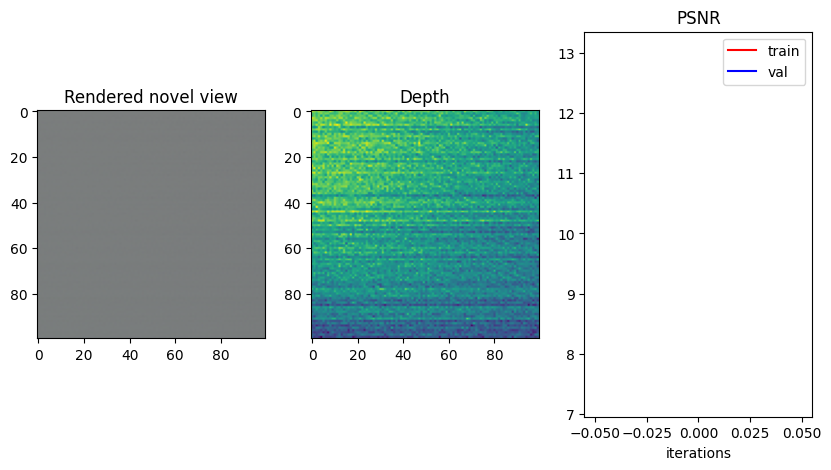

 10%|█         | 500/5000 [01:20<11:34,  6.48it/s]

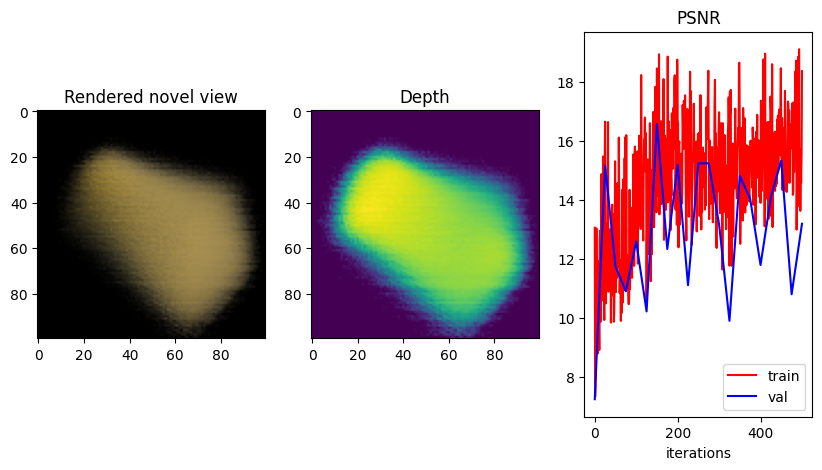

 20%|██        | 1000/5000 [02:40<10:19,  6.46it/s]

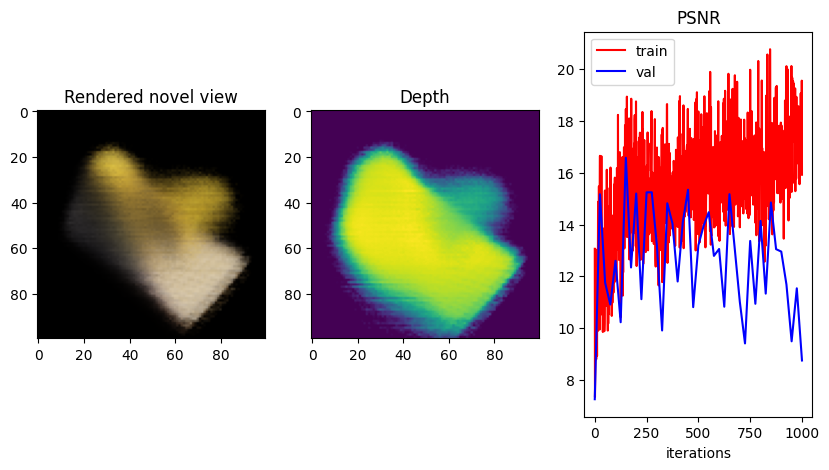

 30%|███       | 1500/5000 [03:59<09:00,  6.47it/s]

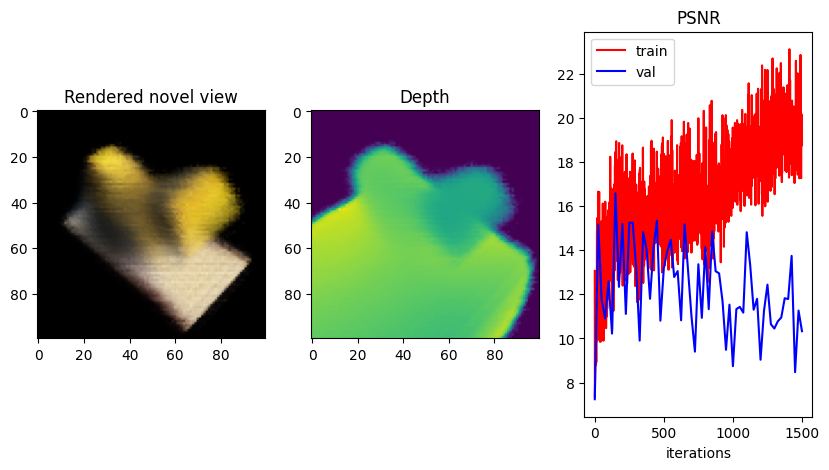

 40%|████      | 2000/5000 [05:19<07:43,  6.48it/s]

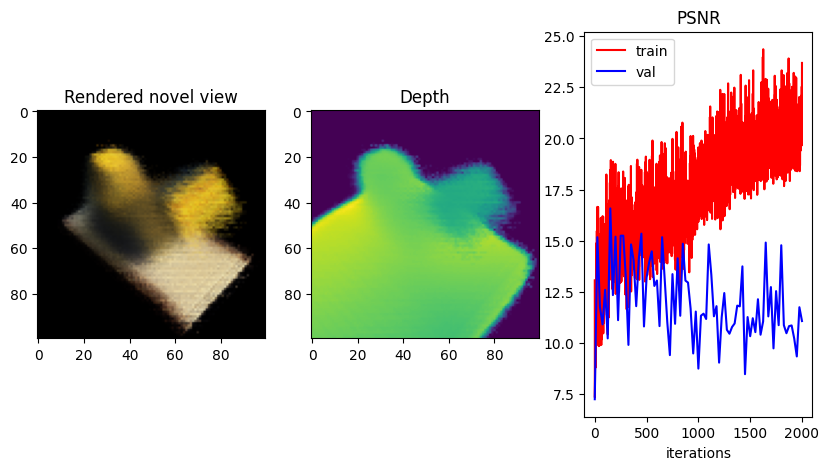

 50%|█████     | 2500/5000 [06:40<06:43,  6.20it/s]

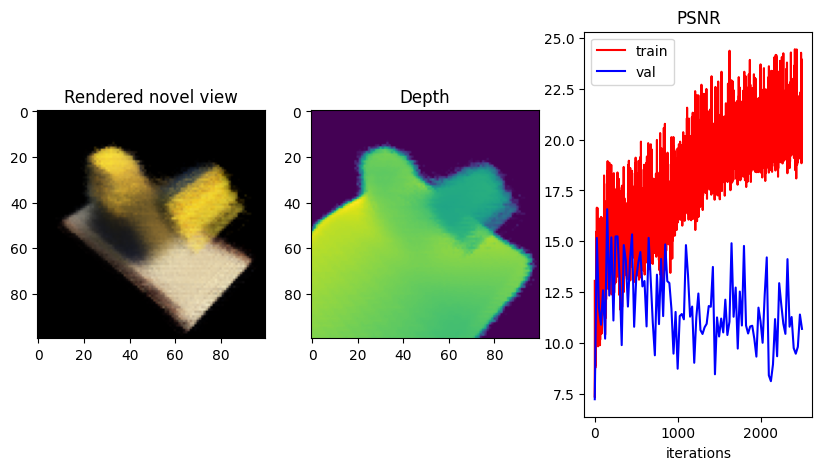

 60%|██████    | 3000/5000 [08:00<05:14,  6.37it/s]

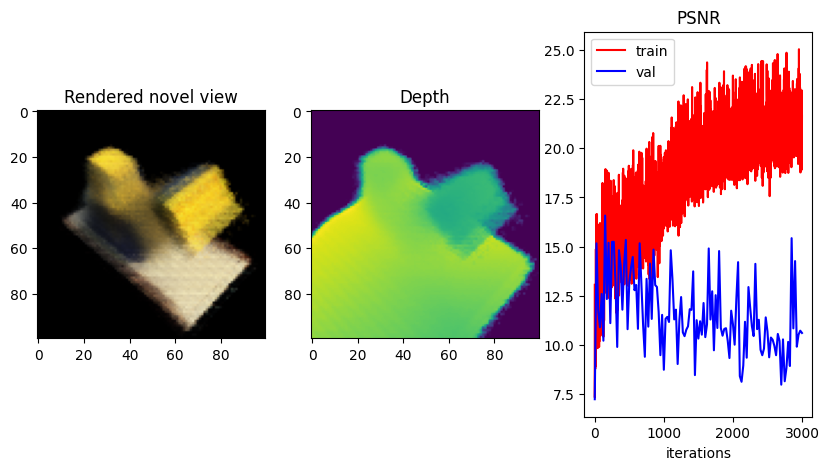

 70%|███████   | 3500/5000 [09:15<03:53,  6.41it/s]

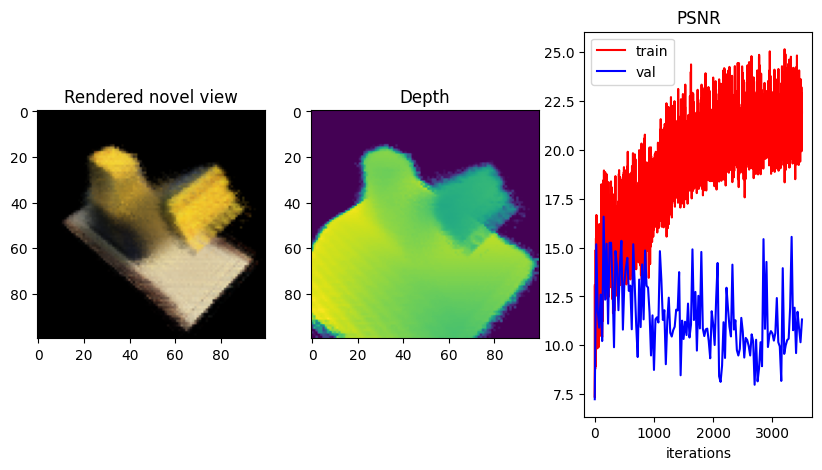

 80%|████████  | 4000/5000 [10:21<01:54,  8.71it/s]

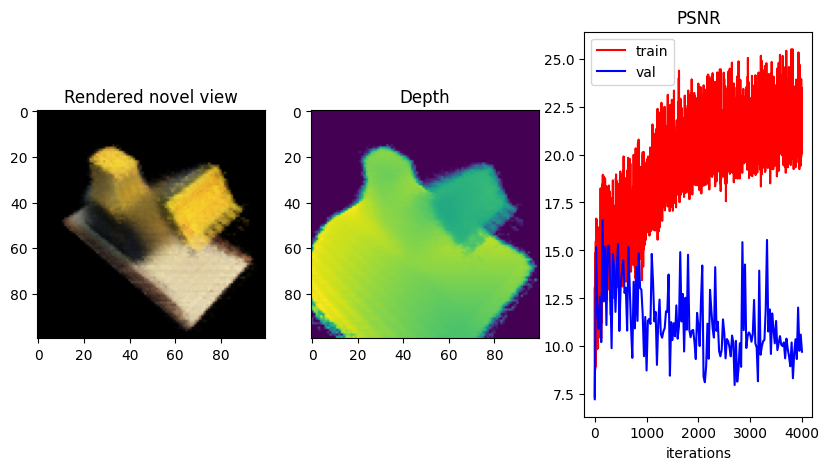

 90%|█████████ | 4500/5000 [11:32<00:56,  8.84it/s]

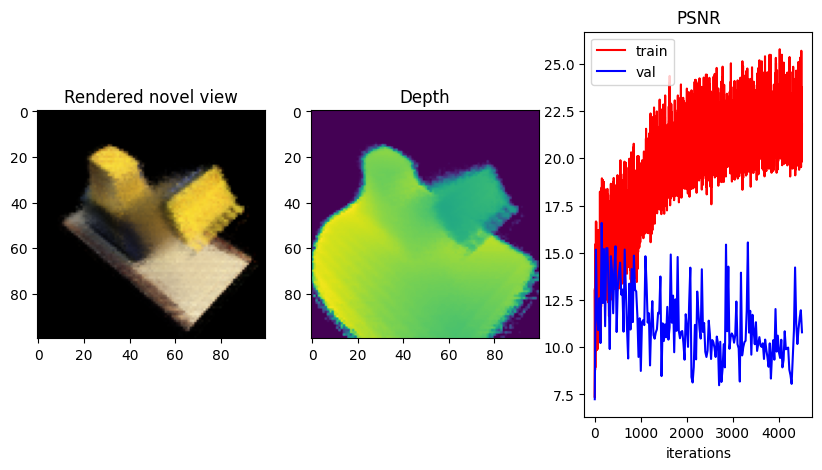

100%|██████████| 5000/5000 [12:36<00:00,  6.61it/s]

Done!


In [12]:
# --- PARAMETERS ---
lr = 5e-3
iterations = 5000
num_encoding_functions = 10
depth_samples_per_ray = 128
near_threshold = 2.
far_threshold = 6.
chunksize = 1024*8
filter_size = 128

display_every = 500

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

# --- MODEL ---
nerf_model = TinyNerfModel(filter_size=filter_size, num_encoding_functions=num_encoding_functions).to(device)
positional_encoding = PositionalEncoding(num_encoding_functions).to(device)

# --- OPTIMIZER ---
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=lr)

# Seeds
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_psnr = []
val_psnr = []
val_iters = []

for i in tqdm(range(iterations)):
    # randomly pick an image and pose to train on
    target_idx = np.random.randint(0, n_training)
    target_img, target_pose = images[target_idx], poses[target_idx]

    # Run one forward pass of NeRF
    rgb_predicted, depth_predicted, acc_predicted = forward_pass(height=images.shape[1],
                                                                    width=images.shape[2],
                                                                    focal_length=focal,
                                                                    pose_cam2world=target_pose,
                                                                    near_threshold=near_threshold,
                                                                    far_threshold=far_threshold,
                                                                    num_samples_per_ray=depth_samples_per_ray,
                                                                    positional_encoding=positional_encoding,
                                                                    nerf_model=nerf_model)
    # Compute the loss
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()                                                                           
    psnr = -10 * torch.log10(loss)
    train_psnr.append(psnr.item())

    if i % (display_every // 20) == 0:
        # Run forward pass on test pose
        rgb_predicted, depth_predicted, acc_predicted = forward_pass(height=images.shape[1],
                                                                        width=images.shape[2],
                                                                        focal_length=focal,
                                                                        pose_cam2world=testpose,
                                                                        near_threshold=near_threshold,
                                                                        far_threshold=far_threshold,
                                                                        num_samples_per_ray=depth_samples_per_ray,
                                                                        positional_encoding=positional_encoding,
                                                                        nerf_model=nerf_model)

        # print(f'Iteration: {i}, Loss PSNR: {psnr.item()}')Loss
        # Compute the loss
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        psnr = -10 * torch.log10(loss)
        val_psnr.append(psnr.item())
        val_iters.append(i)

        if i % display_every == 0:    
            ax = plt.figure(figsize=(10, 5))
            ax = plt.subplot(131)
            ax.imshow(rgb_predicted.cpu().detach().numpy())
            ax.set_title('Rendered novel view')
            
            ax = plt.subplot(132)
            ax.imshow(depth_predicted.cpu().detach().numpy())
            ax.set_title('Depth')

            ax = plt.subplot(133)
            ax.plot(range(0, i+1), train_psnr, color='r', label='train')
            ax.plot(val_iters, val_psnr, color='b', label='val')
            ax.set_xlabel('iterations')
            ax.legend()
            ax.set_title('PSNR')        

        plt.show()

print("Done!")
